<a href="https://colab.research.google.com/github/linneverh/Sust-Finance/blob/Assignment-2/Assignment_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment: Portfolio Allocation based on Financial Performance**

In [24]:
# Import packages

# installing PyPortfolioOpt
!pip install pyportfolioopt
!pip install cvxpy

# installing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar
import yfinance as yf
import scipy.optimize as sco
import scipy.interpolate as sci
import matplotlib.pyplot as plt
import cvxpy as cp
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from datetime import datetime, timedelta
from scipy.optimize import minimize
from pypfopt.objective_functions import portfolio_return
from tqdm import tqdm

In [25]:
#import dataset from git
url_DS_ESGScore_Y = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_ESGScore_Y.csv'
DS_ESGScore_Y = pd.read_csv(url_DS_ESGScore_Y)

url_DS_EScore_Y = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_EScore_Y.csv'
DS_EScore_Y = pd.read_csv(url_DS_EScore_Y)

url_DS_MV_USD_M = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_MV_USD_M.csv'
DS_MV_USD_M = pd.read_csv(url_DS_MV_USD_M)

url_DS_MV_USD_Y = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_MV_USD_Y.csv'
DS_MV_USD_Y = pd.read_csv(url_DS_MV_USD_M)

url_DS_REV_USD_Y = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_REV_USD_Y.csv'
DS_REV_USD_Y = pd.read_csv(url_DS_REV_USD_Y)

url_DS_RI_USD_M = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_RI_USD_M.csv'
DS_RI_USD_M = pd.read_csv(url_DS_RI_USD_M)

url_DS_RI_USD_Y = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_RI_USD_Y.csv'
DS_RI_USD_Y = pd.read_csv(url_DS_RI_USD_M)

url_Risk_Free_Rate = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/Risk_Free_Rate.csv'
Risk_Free_Rate = pd.read_csv(url_Risk_Free_Rate)

url_Static = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/Static.csv'
Static = pd.read_csv(url_Static)


<ipython-input-25-c9f8fe89ee9e>:9: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  DS_MV_USD_M = pd.read_csv(url_DS_MV_USD_M)
<ipython-input-25-c9f8fe89ee9e>:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  DS_MV_USD_Y = pd.read_csv(url_DS_MV_USD_M)


## **Question 4: Minimum variance portfolio (40 points)**

### Return index and percentage data frame

#### MERGING RETURNS TABLE AND ESCORE TABLE FOR EM COUNTRIES

In [26]:
# Merging the data to filter per region
merged_DS_RI_USD_M = pd.merge(DS_RI_USD_M, Static, on='ISIN', how='inner')
merged_DS_RI_USD_M = merged_DS_RI_USD_M[['ISIN', 'Name', 'Country', 'Region'] + [col for col in merged_DS_RI_USD_M.columns if col not in ['ISIN', 'Name', 'Country', 'Region']]]
del(merged_DS_RI_USD_M['NAME'])

#Keeping only the columns between 30/01/04 and 31/12/24
start_date = pd.to_datetime('2008-12-31')
end_date = pd.to_datetime('2024-12-31')

# Filter columns excluding non-date columns
date_columns = [col for col in merged_DS_RI_USD_M.columns if col not in ['ISIN', 'Name', 'Country', 'Region'] and start_date <= pd.to_datetime(col, errors='ignore') <= end_date]
selected_columns = ['ISIN', 'Name', 'Country', 'Region'] + date_columns
merged_DS_RI_USD_M = merged_DS_RI_USD_M[selected_columns]
#merged_DS_RI_USD_M.head()


# Filter on EM countries
EM_merged_DS_RI_USD_M = merged_DS_RI_USD_M[merged_DS_RI_USD_M['Region'] == 'EM']
EM_merged_DS_RI_USD_M

<ipython-input-26-feee87fa7c77>:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  date_columns = [col for col in merged_DS_RI_USD_M.columns if col not in ['ISIN', 'Name', 'Country', 'Region'] and start_date <= pd.to_datetime(col, errors='ignore') <= end_date]


,ISIN,Name,Country,Region,2008-12-31 00:00:00,2009-01-30 00:00:00,2009-02-27 00:00:00,2009-03-31 00:00:00,2009-04-30 00:00:00,2009-05-29 00:00:00,...,2024-03-29 00:00:00,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-28 00:00:00,2024-07-31 00:00:00,2024-08-30 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-29 00:00:00,2024-12-31 00:00:00
1,ARALUA010258,ALUAR,AR,EM,1742.20,1638.06,1242.49,1130.96,1270.87,1450.59,...,5760.96,5331.65,6253.43,5993.00,5680.53,5323.94,4928.66,4706.05,5207.18,4802.89
2,ARP125991090,BANCO BBVA ARGENTINA,AR,EM,73.66,63.74,51.65,60.00,68.34,96.48,...,412.77,458.42,672.82,624.64,569.69,669.66,637.87,774.26,885.63,1067.88
3,ARSIDE010029,TERNIUM ARGENTINA SOCIEDAD ANONIMA,AR,EM,198.77,172.44,129.34,121.38,113.08,117.02,...,1182.67,1092.52,1295.37,1215.48,1155.27,999.71,974.26,916.65,1076.94,982.55
118,BMG211591018,CHINA YURUN FOOD GROUP,CN,EM,32.48,32.78,32.71,35.23,32.91,38.78,...,0.63,0.59,0.59,0.56,0.51,0.59,0.62,0.80,0.67,0.63
146,BRABEVACNOR1,AMBEV ON,BR,EM,394.23,377.41,385.15,439.05,499.37,600.61,...,1199.78,1127.14,1057.57,987.73,985.01,1091.85,1154.89,1049.92,1025.18,963.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,ZAE000191342,ALTRON LIMITED A,ZA,EM,118.52,113.91,93.10,102.74,126.74,139.73,...,103.80,108.05,121.84,131.64,173.36,175.55,184.07,190.50,209.13,210.60
2561,ZAE000255915,ABSA GROUP,ZA,EM,229.96,179.19,174.18,206.75,237.39,258.24,...,373.17,386.72,396.75,434.53,439.89,495.99,531.01,497.48,498.09,524.49
2562,ZAE000298253,NORTHAM PLATINUM HLDGS,ZA,EM,16.97,13.06,16.55,20.93,25.86,32.95,...,53.35,59.43,61.64,62.37,70.16,53.12,56.97,66.32,56.06,46.48
2563,ZAE000302618,AVENG,ZA,EM,68.95,53.69,53.19,56.84,80.05,90.09,...,0.05,0.05,0.05,0.06,0.08,0.09,0.09,0.08,0.10,0.10


In [27]:
start_year = pd.to_datetime('2008-12-31')
end_year = pd.to_datetime('2024-12-31')

# Select columns within the desired date range for returns calculation
date_columns_filtered = [col for col in EM_merged_DS_RI_USD_M.columns[4:]
                         if start_year <= pd.to_datetime(col, errors='coerce') <= end_year
                         and pd.notna(pd.to_datetime(col, errors='coerce'))]  # Check for valid dates

EM_merged_DS_R_USD_M = EM_merged_DS_RI_USD_M[['ISIN', 'Name', 'Country', 'Region'] + date_columns_filtered].copy()  # Create a copy to avoid modifying the original

# Get the date columns for calculations
date_columns = EM_merged_DS_RI_USD_M.columns[4:]  # Assuming the date columns start from index 6

# Iterate through the date columns and calculate simple returns
for i in range(len(date_columns_filtered)-1):
    current_date = date_columns_filtered[i]
    next_date = date_columns_filtered[i + 1]
    # Check if the current_date value is 0
    EM_merged_DS_R_USD_M[next_date] = np.where(EM_merged_DS_RI_USD_M[current_date] != 0,#CLEANING OF THE INFINITE VALUES

                                              (EM_merged_DS_RI_USD_M[next_date] - EM_merged_DS_RI_USD_M[current_date]) / EM_merged_DS_RI_USD_M[current_date],
                                              0)  # Set return rate to 0 if current_date is 0

#Checking if the column to be dropped is present in EM_merged_DS_R_USD_M
if date_columns_filtered:
    EM_merged_DS_R_USD_M = EM_merged_DS_R_USD_M.drop(columns=[date_columns_filtered[0]])

# Now EM_merged_DS_R_USD_M contains the simple returns
EM_merged_DS_R_USD_M

,ISIN,Name,Country,Region,2009-01-30 00:00:00,2009-02-27 00:00:00,2009-03-31 00:00:00,2009-04-30 00:00:00,2009-05-29 00:00:00,2009-06-30 00:00:00,...,2024-03-29 00:00:00,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-28 00:00:00,2024-07-31 00:00:00,2024-08-30 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-29 00:00:00,2024-12-31 00:00:00
1,ARALUA010258,ALUAR,AR,EM,-0.059775,-0.241487,-0.089763,0.123709,0.141415,0.347762,...,0.121748,-0.074521,0.172888,-0.041646,-0.052139,-0.062774,-0.074246,-0.045166,0.106486,-0.077641
2,ARP125991090,BANCO BBVA ARGENTINA,AR,EM,-0.134673,-0.189677,0.161665,0.139000,0.411765,0.032546,...,0.322091,0.110594,0.467693,-0.071609,-0.087971,0.175481,-0.047472,0.213821,0.143841,0.205786
3,ARSIDE010029,TERNIUM ARGENTINA SOCIEDAD ANONIMA,AR,EM,-0.132465,-0.249942,-0.061543,-0.068380,0.034843,0.319518,...,0.158254,-0.076226,0.185672,-0.061673,-0.049536,-0.134653,-0.025457,-0.059132,0.174865,-0.087646
118,BMG211591018,CHINA YURUN FOOD GROUP,CN,EM,0.009236,-0.002135,0.077041,-0.065853,0.178365,0.083032,...,-0.045455,-0.063492,0.000000,-0.050847,-0.089286,0.156863,0.050847,0.290323,-0.162500,-0.059701
146,BRABEVACNOR1,AMBEV ON,BR,EM,-0.042665,0.020508,0.139945,0.137388,0.202735,-0.015351,...,-0.014473,-0.060544,-0.061723,-0.066038,-0.002754,0.108466,0.057737,-0.090892,-0.023564,-0.060048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,ZAE000191342,ALTRON LIMITED A,ZA,EM,-0.038896,-0.182688,0.103545,0.233599,0.102493,0.190152,...,0.082942,0.040944,0.127626,0.080433,0.316925,0.012633,0.048533,0.034932,0.097795,0.007029
2561,ZAE000255915,ABSA GROUP,ZA,EM,-0.220778,-0.027959,0.186990,0.148198,0.087830,0.127362,...,-0.082512,0.036311,0.025936,0.095224,0.012335,0.127532,0.070606,-0.063144,0.001226,0.053002
2562,ZAE000298253,NORTHAM PLATINUM HLDGS,ZA,EM,-0.230407,0.267228,0.264653,0.235547,0.274169,-0.087102,...,0.052891,0.113964,0.037187,0.011843,0.124900,-0.242873,0.072477,0.164121,-0.154704,-0.170888
2563,ZAE000302618,AVENG,ZA,EM,-0.221320,-0.009313,0.068622,0.408339,0.125422,0.043845,...,-0.166667,0.000000,0.000000,0.200000,0.333333,0.125000,0.000000,-0.111111,0.250000,0.000000


In [28]:
# Merging the EScore to EM, from 2003 to 2023

merged_DS_EScore_Y = pd.merge(DS_EScore_Y, Static, on='ISIN', how='inner')
merged_DS_EScore_Y = merged_DS_EScore_Y[['ISIN', 'Name', 'Region'] + [col for col in merged_DS_EScore_Y.columns if col not in ['ISIN', 'Name', 'Region', 'NAME']]]

#Keeping only the columns between 31/12/03 and 31/12/23
start_date = pd.to_datetime('2008-12-31')
end_date = pd.to_datetime('2023-12-31')

# Filter columns excluding non-date columns
date_columns = [col for col in merged_DS_EScore_Y.columns if col not in ['ISIN', 'Name', 'Country', 'Region'] and start_date <= pd.to_datetime(col, errors='ignore') <= end_date]
selected_columns = ['ISIN', 'Name', 'Country', 'Region'] + date_columns
merged_DS_EScore_Y = merged_DS_EScore_Y[selected_columns]


# Filter on EM countries
EM_merged_DS_EScore_Y = merged_DS_EScore_Y[merged_DS_EScore_Y['Region'] == 'EM']
EM_merged_DS_EScore_Y

<ipython-input-28-d041599f5589>:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  date_columns = [col for col in merged_DS_EScore_Y.columns if col not in ['ISIN', 'Name', 'Country', 'Region'] and start_date <= pd.to_datetime(col, errors='ignore') <= end_date]


,ISIN,Name,Country,Region,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,ARALUA010258,ALUAR,AR,EM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.82,13.26,12.26,11.05,13.19,12.21,17.65
2,ARP125991090,BANCO BBVA ARGENTINA,AR,EM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.51,56.64,76.16,84.68,82.48,88.36,86.99,79.68
3,ARSIDE010029,TERNIUM ARGENTINA SOCIEDAD ANONIMA,AR,EM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.51,33.47,33.72,33.41,33.52,38.37,36.83,48.05
118,BMG211591018,CHINA YURUN FOOD GROUP,CN,EM,0.0,0.00,0.00,0.00,0.00,0.00,0.00,17.85,36.12,45.19,48.35,52.97,63.43,53.70,47.78
145,BRABEVACNOR1,AMBEV ON,BR,EM,NaN,NaN,NaN,NaN,57.38,58.81,66.63,74.17,67.08,55.27,68.85,72.11,77.48,67.51,62.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,ZAE000191342,ALTRON LIMITED A,ZA,EM,NaN,NaN,NaN,43.78,44.42,54.31,56.78,59.55,57.53,30.93,30.08,27.51,38.62,31.87,37.06
2504,ZAE000255915,ABSA GROUP,ZA,EM,52.2,53.90,48.96,58.02,56.43,55.56,68.94,75.90,81.90,80.63,83.03,81.99,81.45,79.12,84.75
2505,ZAE000298253,NORTHAM PLATINUM HLDGS,ZA,EM,NaN,60.96,53.53,59.07,54.34,54.03,52.42,56.64,53.90,63.37,62.03,67.79,73.50,74.37,63.96
2506,ZAE000302618,AVENG,ZA,EM,NaN,58.89,62.27,78.98,72.99,64.66,69.09,70.85,52.33,45.73,44.32,44.52,48.95,31.21,25.61


In [29]:
# Filling in missing ESG
df_filled = EM_merged_DS_EScore_Y.copy()

# Identify the year columns (assuming they are strings representing years)
year_columns = sorted([col for col in df_filled.columns if col.isdigit()])

# Iterate through the year columns
for i in range(1, len(year_columns)):
    prev_year = year_columns[i-1]
    current_year = year_columns[i]

    # Create a mask to select rows where:
    # 1. The current year is NaN
    # 2. The previous year is NOT NaN
    # 3. The previous year's value is a float
    mask = (df_filled[current_year].isna()) & \
           (df_filled[prev_year].notna()) & \
           (df_filled[prev_year].apply(lambda x: isinstance(x, (int, float)))) #check if int or float (not only float)

    # Fill the NaN values in the current year with the previous year's float value
    df_filled.loc[mask, current_year] = df_filled.loc[mask, prev_year]

# Update DS_ESGScore_Y_filtered with the filled values
EM_merged_DS_EScore_Y = df_filled

In [30]:
#FILTERING ONLY FIRMS WITH AN E SCORE FROM 2013 ON

# Remplacer les chaînes de caractères "NaN" par np.nan
EM_merged_DS_EScore_Y = EM_merged_DS_EScore_Y.replace('NaN', np.nan)
EM_merged_DS_EScore_Y = EM_merged_DS_EScore_Y.replace(0, np.nan)

# Convert date columns to datetime if they are not already
date_columns = EM_merged_DS_EScore_Y.columns[4:]  # Assuming 'ISIN', 'Name', 'Country', 'Region' are the first 4 columns
EM_merged_DS_EScore_Y.columns = EM_merged_DS_EScore_Y.columns[:4].tolist() + pd.to_datetime(date_columns, errors='coerce').tolist()

# Select columns from 2013 onwards
start_date = pd.to_datetime('2013-12-31')
date_columns_2013_onwards = [col for col in EM_merged_DS_EScore_Y.columns
                             if isinstance(col, pd.Timestamp) and col >= start_date]

# Filter for rows with no NaN values in the selected columns
EM_merged_DS_EScore_Y = EM_merged_DS_EScore_Y[
    EM_merged_DS_EScore_Y[date_columns_2013_onwards].notna().all(axis=1)
]
EM_merged_DS_EScore_Y

,ISIN,Name,Country,Region,2009-01-01 00:00:00,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00,2013-01-01 00:00:00,2014-01-01 00:00:00,2015-01-01 00:00:00,2016-01-01 00:00:00,2017-01-01 00:00:00,2018-01-01 00:00:00,2019-01-01 00:00:00,2020-01-01 00:00:00,2021-01-01 00:00:00,2022-01-01 00:00:00,2023-01-01 00:00:00
145,BRABEVACNOR1,AMBEV ON,BR,EM,NaN,NaN,NaN,NaN,57.38,58.81,66.63,74.17,67.08,55.27,68.85,72.11,77.48,67.51,62.78
146,BRBBASACNOR3,BANCO DO BRASIL ON,BR,EM,68.98,87.93,85.72,87.23,89.93,90.21,91.78,94.54,94.64,94.43,94.44,91.44,91.20,92.86,93.30
147,BRBBDCACNPR8,BANCO BRADESCO PN,BR,EM,78.70,84.85,86.45,81.49,80.31,83.16,88.79,95.72,96.06,96.32,95.57,94.90,95.52,94.60,97.80
148,BRBRFSACNOR8,BRF BRASIL FOODS ON,BR,EM,53.61,42.42,65.34,77.78,75.80,78.70,75.73,77.90,77.55,77.98,72.71,77.44,81.78,82.94,82.34
149,BRBRKMACNPA4,BRASKEM PN A,BR,EM,58.64,58.57,61.40,57.79,57.57,41.05,44.03,43.06,50.40,53.56,49.96,50.09,51.08,48.23,50.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,ZAE000191342,ALTRON LIMITED A,ZA,EM,NaN,NaN,NaN,43.78,44.42,54.31,56.78,59.55,57.53,30.93,30.08,27.51,38.62,31.87,37.06
2504,ZAE000255915,ABSA GROUP,ZA,EM,52.20,53.90,48.96,58.02,56.43,55.56,68.94,75.90,81.90,80.63,83.03,81.99,81.45,79.12,84.75
2505,ZAE000298253,NORTHAM PLATINUM HLDGS,ZA,EM,NaN,60.96,53.53,59.07,54.34,54.03,52.42,56.64,53.90,63.37,62.03,67.79,73.50,74.37,63.96
2506,ZAE000302618,AVENG,ZA,EM,NaN,58.89,62.27,78.98,72.99,64.66,69.09,70.85,52.33,45.73,44.32,44.52,48.95,31.21,25.61


In [31]:
# #KEEPING ONLY FIRMS, FROM THE RETURNS TABLE, WITH AN E SCORE FROM 2013 ON

# Create a list of ISINs present in EM_merged_DS_EScore_Y
isin_list = EM_merged_DS_EScore_Y['ISIN'].tolist()

# Filter EM_merged_DS_R_USD_M to keep only rows with ISINs present in the list
filtered_EM_merged_DS_R_USD_M = EM_merged_DS_R_USD_M[EM_merged_DS_R_USD_M['ISIN'].isin(isin_list)].copy()
filtered_EM_merged_DS_R_USD_M

,ISIN,Name,Country,Region,2009-01-30 00:00:00,2009-02-27 00:00:00,2009-03-31 00:00:00,2009-04-30 00:00:00,2009-05-29 00:00:00,2009-06-30 00:00:00,...,2024-03-29 00:00:00,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-28 00:00:00,2024-07-31 00:00:00,2024-08-30 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-29 00:00:00,2024-12-31 00:00:00
146,BRABEVACNOR1,AMBEV ON,BR,EM,-0.042665,0.020508,0.139945,0.137388,0.202735,-0.015351,...,-0.014473,-0.060544,-0.061723,-0.066038,-0.002754,0.108466,0.057737,-0.090892,-0.023564,-0.060048
147,BRBBASACNOR3,BANCO DO BRASIL ON,BR,EM,-0.029038,-0.024663,0.270417,0.161538,0.267537,0.015014,...,-0.021737,-0.064611,-0.024629,-0.044654,-0.023276,0.075064,0.011822,-0.088666,-0.070730,-0.050255
148,BRBBDCACNPR8,BANCO BRADESCO PN,BR,EM,-0.072389,-0.023411,0.155468,0.248645,0.234734,-0.036107,...,0.030787,-0.050563,-0.106172,-0.069301,-0.004353,0.265222,-0.015599,-0.072711,-0.140684,-0.108998
149,BRBRFSACNOR8,BRF BRASIL FOODS ON,BR,EM,0.080043,-0.094964,0.001767,0.190736,0.338332,-0.038486,...,0.072827,-0.001119,0.085479,0.154542,-0.087171,0.243162,-0.062344,0.043383,-0.061078,-0.007831
150,BRBRKMACNPA4,BRASKEM PN A,BR,EM,0.032655,-0.078423,-0.077588,0.361663,0.277753,0.007898,...,0.245496,-0.221552,-0.124134,-0.105816,-0.034452,0.026009,0.148867,-0.171098,-0.171820,-0.253886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,ZAE000191342,ALTRON LIMITED A,ZA,EM,-0.038896,-0.182688,0.103545,0.233599,0.102493,0.190152,...,0.082942,0.040944,0.127626,0.080433,0.316925,0.012633,0.048533,0.034932,0.097795,0.007029
2561,ZAE000255915,ABSA GROUP,ZA,EM,-0.220778,-0.027959,0.186990,0.148198,0.087830,0.127362,...,-0.082512,0.036311,0.025936,0.095224,0.012335,0.127532,0.070606,-0.063144,0.001226,0.053002
2562,ZAE000298253,NORTHAM PLATINUM HLDGS,ZA,EM,-0.230407,0.267228,0.264653,0.235547,0.274169,-0.087102,...,0.052891,0.113964,0.037187,0.011843,0.124900,-0.242873,0.072477,0.164121,-0.154704,-0.170888
2563,ZAE000302618,AVENG,ZA,EM,-0.221320,-0.009313,0.068622,0.408339,0.125422,0.043845,...,-0.166667,0.000000,0.000000,0.200000,0.333333,0.125000,0.000000,-0.111111,0.250000,0.000000


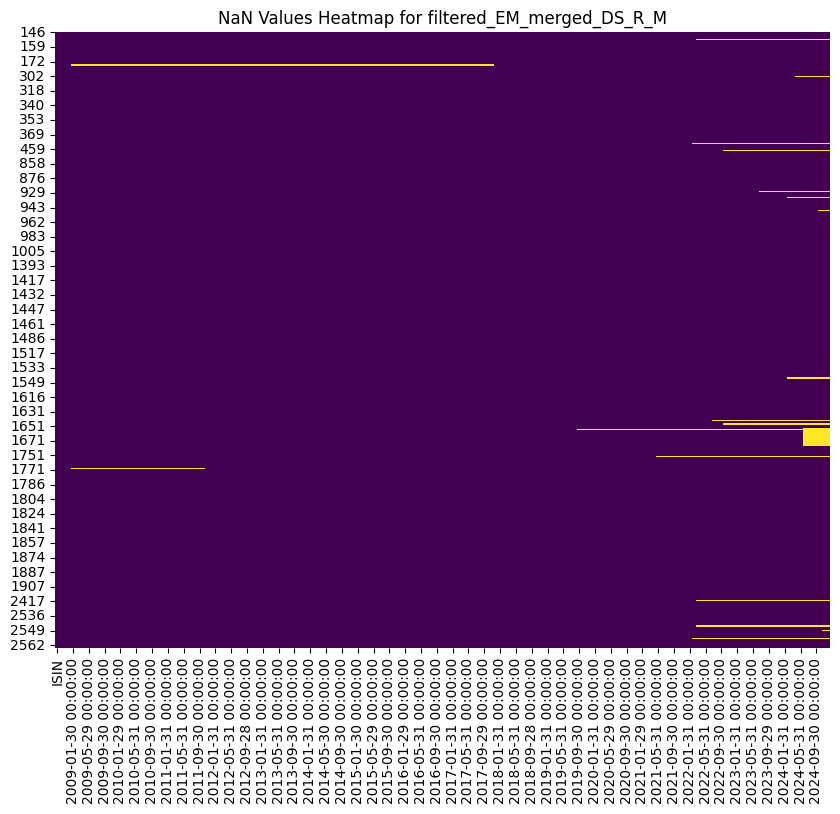

In [32]:
# CREATE HEATMAP OF NAN VALUES

filtered_EM_merged_DS_R_USD_M = filtered_EM_merged_DS_R_USD_M.replace('NaN', np.nan) #making sure the nan values are recognized as such
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_EM_merged_DS_R_USD_M.isnull(), cbar=False, cmap='viridis')
plt.title('NaN Values Heatmap for filtered_EM_merged_DS_R_M')
plt.show()


#### HATZOLD RULE: NAN VALUES BETWEEN 2014 AND 2024

In the following part, we will first try to identify which firms to get rid of because of missing values ( time frame: 2004-2024: correct? )

In [33]:
#WHERE ARE THE NAN VALUES SHERLOCK?

# Filter columns for 2014-2024
start_date = pd.to_datetime('2008-12-31')

# Select columns within the desired date range
date_columns_filtered = [col for col in filtered_EM_merged_DS_R_USD_M.columns[4:]
                        if pd.to_datetime(col, errors='coerce') >= start_date
                        and pd.notna(pd.to_datetime(col, errors='coerce'))]

# Filter the DataFrame to keep only the selected columns
filtered_EM_merged_DS_R_USD_M_filtered = filtered_EM_merged_DS_R_USD_M[['ISIN', 'Name', 'Country', 'Region'] + date_columns_filtered].copy()


# Now, find rows with NaN values within the filtered DataFrame
nan_rows = filtered_EM_merged_DS_R_USD_M_filtered[filtered_EM_merged_DS_R_USD_M_filtered.isna().any(axis=1)]

# Assign nan_rows to nan_rows_df
nan_rows_df = nan_rows #Assign the DataFrame

# Display the DataFrame containing the rows with NaN values
print("DataFrame with NaN rows:\n", nan_rows_df.to_string())

DataFrame with NaN rows:
               ISIN                                           Name Country Region  2009-01-30 00:00:00  2009-02-27 00:00:00  2009-03-31 00:00:00  2009-04-30 00:00:00  2009-05-29 00:00:00  2009-06-30 00:00:00  2009-07-31 00:00:00  2009-08-31 00:00:00  2009-09-30 00:00:00  2009-10-30 00:00:00  2009-11-30 00:00:00  2009-12-31 00:00:00  2010-01-29 00:00:00  2010-02-26 00:00:00  2010-03-31 00:00:00  2010-04-30 00:00:00  2010-05-31 00:00:00  2010-06-30 00:00:00  2010-07-30 00:00:00  2010-08-31 00:00:00  2010-09-30 00:00:00  2010-10-29 00:00:00  2010-11-30 00:00:00  2010-12-31 00:00:00  2011-01-31 00:00:00  2011-02-28 00:00:00  2011-03-31 00:00:00  2011-04-29 00:00:00  2011-05-31 00:00:00  2011-06-30 00:00:00  2011-07-29 00:00:00  2011-08-31 00:00:00  2011-09-30 00:00:00  2011-10-31 00:00:00  2011-11-30 00:00:00  2011-12-30 00:00:00  2012-01-31 00:00:00  2012-02-29 00:00:00  2012-03-30 00:00:00  2012-04-30 00:00:00  2012-05-31 00:00:00  2012-06-29 00:00:00  2012-07-31

In [34]:
#FILTERING NAN VALUES STEP 1: IDENTIFYING "SUSP" or "DELIST" CASES

# Access the company names
company_names = nan_rows_df['Name']

# Filter company names that do contain "SUSP" or "DELIST"
filtered_indices = company_names[company_names.str.contains("SUSP|DELIST", case=False, na=False)].index.tolist()
filtered_indices
num_selected_indices = len(filtered_indices)
print("Number of selected indices:", num_selected_indices)

Number of selected indices: 13


In [35]:
#FILTERING NAN VALUES STEP 2: IDENTIFYING FIRMS WE NEED TO GET RID OF

selected_rows = nan_rows_df.loc[filtered_indices]
nan_rows_df = nan_rows_df.drop(selected_rows.index) #removing the row with nan values that is from a delisted firm
nan_rows_df

,ISIN,Name,Country,Region,2009-01-30 00:00:00,2009-02-27 00:00:00,2009-03-31 00:00:00,2009-04-30 00:00:00,2009-05-29 00:00:00,2009-06-30 00:00:00,...,2024-03-29 00:00:00,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-28 00:00:00,2024-07-31 00:00:00,2024-08-30 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-29 00:00:00,2024-12-31 00:00:00
175,BRSUZBACNOR0,SUZANO ON,BR,EM,NaN,NaN,NaN,NaN,NaN,NaN,...,0.127116,-0.117545,-0.178531,0.107769,-0.071750,0.019372,0.029266,0.032866,0.012156,-0.012010
928,INE001A01036,HOUSING DEVELOPMENT FINANCE CORPORATION,IN,EM,0.027051,-0.204636,0.116893,0.239958,0.340349,0.058020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1660,RU0007288411,MMC NORILSK NICKEL,RU,EM,-0.364783,0.142368,0.282205,0.376168,0.347368,-0.199597,...,0.020696,0.008713,-0.059271,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1661,RU0007661302,URALKALI,RU,EM,-0.277027,0.018692,0.834862,0.025000,0.570732,-0.152174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1662,RU0007661625,GAZPROM,RU,EM,-0.092593,0.012021,0.147514,0.198844,0.296988,-0.135934,...,-0.043806,0.028058,-0.198507,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1663,RU0008943394,ROSTELECOM,RU,EM,-0.003745,-0.071429,0.101767,0.063972,-0.222449,-0.287906,...,0.099924,-0.060564,-0.019780,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1664,RU0009024277,NK LUKOIL,RU,EM,0.033198,-0.016434,0.161347,0.200988,0.226533,-0.169825,...,0.007134,0.060470,-0.000717,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1665,RU0009029540,SBERBANK OF RUSSIA,RU,EM,-0.389310,-0.135165,0.545478,0.366711,0.729622,-0.147486,...,0.006059,0.021924,0.050651,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1666,RU0009033591,TATNEFT,RU,EM,-0.087564,0.128226,0.263045,0.286927,0.632366,-0.149246,...,-0.049490,0.024555,-0.008595,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1667,RU0009046510,SEVERSTAL,RU,EM,-0.085890,0.436242,-0.051402,0.187192,0.377593,-0.057229,...,0.118778,0.016615,-0.045983,NaN,NaN,NaN,NaN,NaN,NaN,NaN


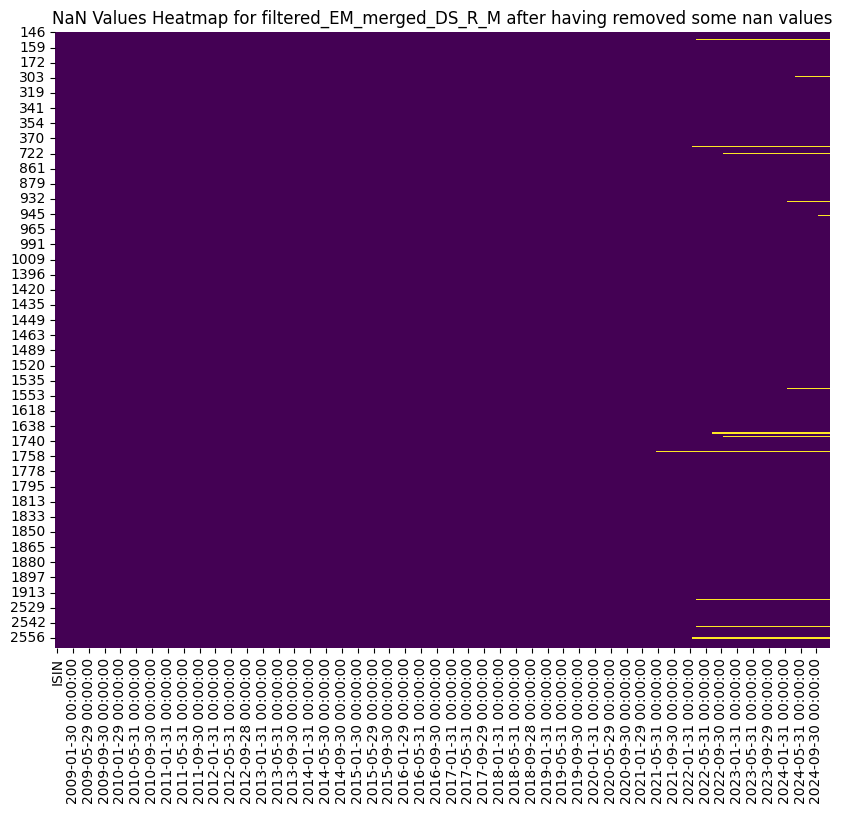

In [36]:
#REMOVING THOSE ROWS FROM OUR TABLE

# Get the indices of rows in nan_rows_df
nan_rows_indices = nan_rows_df.index

# Drop those rows from filtered_EM_merged_DS_R_USD_M
filtered_EM_merged_DS_R_USD_M = filtered_EM_merged_DS_R_USD_M.drop(nan_rows_indices)

#visualizing on heat map
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_EM_merged_DS_R_USD_M.isnull(), cbar=False, cmap='viridis')
plt.title('NaN Values Heatmap for filtered_EM_merged_DS_R_M after having removed some nan values')
plt.show()

In [37]:
#ASSIGNING RETURNS TO 0 FOR FIRMS THAT HAVE DELISTED

#filtered_EM_merged_DS_R_USD_M = filtered_EM_merged_DS_R_USD_M.fillna(0) #CAREFUL BECAUSE FIRST VALUE SHOULD BE -1 AND THEN WE ALLOCATE 0
#filtered_EM_merged_DS_R_USD_M

#visualizing on heat map
#plt.figure(figsize=(10, 8))
#sns.heatmap(filtered_EM_merged_DS_R_USD_M.isnull(), cbar=False, cmap='viridis')
#plt.title('NaN Values Heatmap for filtered_EM_merged_DS_R_M after having removed some nan values')
#plt.show()

#### BICHE RULE: NAN VALUES BETWEEN 2003 AND 2013

In [38]:
#CLEANING NAN WITH THE BICHE RULE

def clean_data(dataframe):

    #Cleans the input DataFrame according to the specified rules:

    #1. If a row in 2014 does not have at least 5 years of prior data (no NaN values), it is deleted.
    #2. If there is a single missing value between existing data points, it is replaced with 0.
    #3. If a missing value appears after 2014, it is filled with the average value of the available period before the actual date.


    # Convert date columns to datetime format
    date_columns = dataframe.columns[4:]
    dataframe.columns = dataframe.columns[:4].tolist() + pd.to_datetime(date_columns, errors='coerce').tolist()

    dataframe = dataframe.copy()  # Avoid modifying original DataFrame

    # 1. Delete rows without 5 years of prior data in 2014
    try: # removed the try block
        year_2014_index = dataframe.columns.get_loc(pd.Timestamp('2014-12-31')) # fixed indentation
    except KeyError:
        print("Warning: '2014-12-31' not found in columns. Skipping step 1.")
        year_2014_index = None

    if year_2014_index is not None:
        prior_years = 5 * 12  # Assuming monthly data
        if year_2014_index >= prior_years:
            dataframe = dataframe[
                dataframe.iloc[:, year_2014_index - prior_years: year_2014_index].notna().sum(axis=1) == prior_years]

    # 2. Replace single missing values between existing data points with 0
    for index in range(len(dataframe)):
        row = dataframe.iloc[index, 4:]  # Extract only the date columns
        for i in range(1, len(row) - 1):
            if pd.isna(row.iloc[i]) and not pd.isna(row.iloc[i - 1]) and not pd.isna(row.iloc[i + 1]):
                dataframe.iloc[index, i + 4] = 0  # Offset by 4 to match original indexing

  # 3. Handle NaNs at the end of the row **only if they occur after 2014**
    if year_2014_index is not None:
       for index in range(len(dataframe)):
            row = dataframe.iloc[index, year_2014_index + 1:]  # Consider only post-2014 data
            nan_indices = row[row.isna()].index

            if not nan_indices.empty:
                first_nan_index = nan_indices[0]  # First NaN occurrence

                # Set first NaN to -1
                dataframe.iloc[index, dataframe.columns.get_loc(first_nan_index)] = -1

                # Fill remaining NaNs with 0
                dataframe.iloc[index, dataframe.columns.get_loc(first_nan_index) + 1:] = dataframe.iloc[index, dataframe.columns.get_loc(first_nan_index) + 1:].fillna(0)

    return dataframe

### Returns dataframe

In [39]:
# Apply the cleaning function to our dataframe filtered_EM_merged_DS_R_USD_M
filtered_EM_merged_DS_R_USD_M = clean_data(filtered_EM_merged_DS_R_USD_M)
filtered_EM_merged_DS_R_USD_M

<ipython-input-38-d037b5986158>:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe.iloc[index, dataframe.columns.get_loc(first_nan_index) + 1:] = dataframe.iloc[index, dataframe.columns.get_loc(first_nan_index) + 1:].fillna(0)
<ipython-input-38-d037b5986158>:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe.iloc[index, dataframe.columns.get_loc(first_nan_index) + 1:] = dataframe.iloc[index, dataframe.columns.get_loc(first_nan_index) + 1:].fillna(0)
<ipython-input-38-d037b5986158>:51: FutureWarning: Downcasting object dtype arrays on .f

,ISIN,Name,Country,Region,2009-01-30 00:00:00,2009-02-27 00:00:00,2009-03-31 00:00:00,2009-04-30 00:00:00,2009-05-29 00:00:00,2009-06-30 00:00:00,...,2024-03-29 00:00:00,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-28 00:00:00,2024-07-31 00:00:00,2024-08-30 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-29 00:00:00,2024-12-31 00:00:00
146,BRABEVACNOR1,AMBEV ON,BR,EM,-0.042665,0.020508,0.139945,0.137388,0.202735,-0.015351,...,-0.014473,-0.060544,-0.061723,-0.066038,-0.002754,0.108466,0.057737,-0.090892,-0.023564,-0.060048
147,BRBBASACNOR3,BANCO DO BRASIL ON,BR,EM,-0.029038,-0.024663,0.270417,0.161538,0.267537,0.015014,...,-0.021737,-0.064611,-0.024629,-0.044654,-0.023276,0.075064,0.011822,-0.088666,-0.070730,-0.050255
148,BRBBDCACNPR8,BANCO BRADESCO PN,BR,EM,-0.072389,-0.023411,0.155468,0.248645,0.234734,-0.036107,...,0.030787,-0.050563,-0.106172,-0.069301,-0.004353,0.265222,-0.015599,-0.072711,-0.140684,-0.108998
149,BRBRFSACNOR8,BRF BRASIL FOODS ON,BR,EM,0.080043,-0.094964,0.001767,0.190736,0.338332,-0.038486,...,0.072827,-0.001119,0.085479,0.154542,-0.087171,0.243162,-0.062344,0.043383,-0.061078,-0.007831
150,BRBRKMACNPA4,BRASKEM PN A,BR,EM,0.032655,-0.078423,-0.077588,0.361663,0.277753,0.007898,...,0.245496,-0.221552,-0.124134,-0.105816,-0.034452,0.026009,0.148867,-0.171098,-0.171820,-0.253886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,ZAE000191342,ALTRON LIMITED A,ZA,EM,-0.038896,-0.182688,0.103545,0.233599,0.102493,0.190152,...,0.082942,0.040944,0.127626,0.080433,0.316925,0.012633,0.048533,0.034932,0.097795,0.007029
2561,ZAE000255915,ABSA GROUP,ZA,EM,-0.220778,-0.027959,0.186990,0.148198,0.087830,0.127362,...,-0.082512,0.036311,0.025936,0.095224,0.012335,0.127532,0.070606,-0.063144,0.001226,0.053002
2562,ZAE000298253,NORTHAM PLATINUM HLDGS,ZA,EM,-0.230407,0.267228,0.264653,0.235547,0.274169,-0.087102,...,0.052891,0.113964,0.037187,0.011843,0.124900,-0.242873,0.072477,0.164121,-0.154704,-0.170888
2563,ZAE000302618,AVENG,ZA,EM,-0.221320,-0.009313,0.068622,0.408339,0.125422,0.043845,...,-0.166667,0.000000,0.000000,0.200000,0.333333,0.125000,0.000000,-0.111111,0.250000,0.000000


In [40]:
isin_list_R = filtered_EM_merged_DS_R_USD_M['ISIN'].tolist()

# Filter EM_merged_DS_EScore_Y to keep only rows with ISINs present in the list
filtered_EM_merged_DS_EScore_Y = EM_merged_DS_EScore_Y[EM_merged_DS_EScore_Y['ISIN'].isin(isin_list_R)].copy()
filtered_EM_merged_DS_EScore_Y


,ISIN,Name,Country,Region,2009-01-01 00:00:00,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00,2013-01-01 00:00:00,2014-01-01 00:00:00,2015-01-01 00:00:00,2016-01-01 00:00:00,2017-01-01 00:00:00,2018-01-01 00:00:00,2019-01-01 00:00:00,2020-01-01 00:00:00,2021-01-01 00:00:00,2022-01-01 00:00:00,2023-01-01 00:00:00
145,BRABEVACNOR1,AMBEV ON,BR,EM,NaN,NaN,NaN,NaN,57.38,58.81,66.63,74.17,67.08,55.27,68.85,72.11,77.48,67.51,62.78
146,BRBBASACNOR3,BANCO DO BRASIL ON,BR,EM,68.98,87.93,85.72,87.23,89.93,90.21,91.78,94.54,94.64,94.43,94.44,91.44,91.20,92.86,93.30
147,BRBBDCACNPR8,BANCO BRADESCO PN,BR,EM,78.70,84.85,86.45,81.49,80.31,83.16,88.79,95.72,96.06,96.32,95.57,94.90,95.52,94.60,97.80
148,BRBRFSACNOR8,BRF BRASIL FOODS ON,BR,EM,53.61,42.42,65.34,77.78,75.80,78.70,75.73,77.90,77.55,77.98,72.71,77.44,81.78,82.94,82.34
149,BRBRKMACNPA4,BRASKEM PN A,BR,EM,58.64,58.57,61.40,57.79,57.57,41.05,44.03,43.06,50.40,53.56,49.96,50.09,51.08,48.23,50.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,ZAE000191342,ALTRON LIMITED A,ZA,EM,NaN,NaN,NaN,43.78,44.42,54.31,56.78,59.55,57.53,30.93,30.08,27.51,38.62,31.87,37.06
2504,ZAE000255915,ABSA GROUP,ZA,EM,52.20,53.90,48.96,58.02,56.43,55.56,68.94,75.90,81.90,80.63,83.03,81.99,81.45,79.12,84.75
2505,ZAE000298253,NORTHAM PLATINUM HLDGS,ZA,EM,NaN,60.96,53.53,59.07,54.34,54.03,52.42,56.64,53.90,63.37,62.03,67.79,73.50,74.37,63.96
2506,ZAE000302618,AVENG,ZA,EM,NaN,58.89,62.27,78.98,72.99,64.66,69.09,70.85,52.33,45.73,44.32,44.52,48.95,31.21,25.61


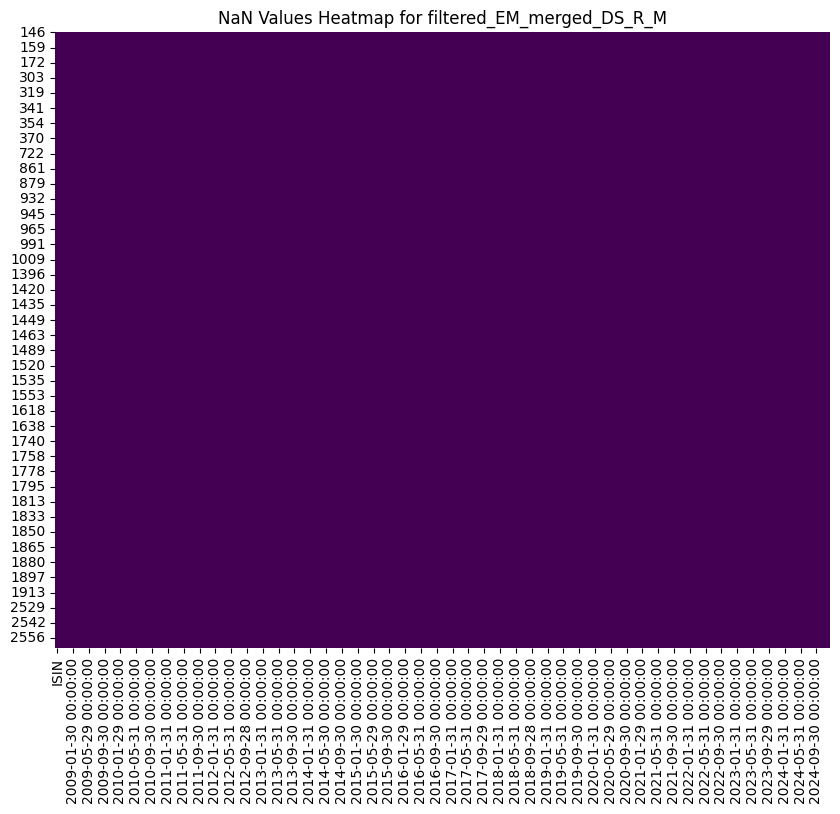

In [41]:
#Heat map for the NaN values in filtered_EM_merged_DS_R_M

# Create a heatmap of NaN values
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_EM_merged_DS_R_USD_M.isnull(), cbar=False, cmap='viridis')
plt.title('NaN Values Heatmap for filtered_EM_merged_DS_R_M')
plt.show()

###REBALANCED PORTFOLIO


In [42]:
#WIDE TO LONG FORMAT FOR OUR DATAFRAME

long_filtered_EM_merged_DS_R_USD_M = pd.melt(filtered_EM_merged_DS_R_USD_M,
                        id_vars=['ISIN', 'Name', 'Country', 'Region'],  # Columns to keep as identifiers
                        var_name='Date',
                        value_name='Returns')

long_filtered_EM_merged_DS_R_USD_M['Date'] = pd.to_datetime(long_filtered_EM_merged_DS_R_USD_M['Date'])

# Display the long-format DataFrame
long_filtered_EM_merged_DS_R_USD_M.head()

,ISIN,Name,Country,Region,Date,Returns
0,BRABEVACNOR1,AMBEV ON,BR,EM,2009-01-30,-0.042665
1,BRBBASACNOR3,BANCO DO BRASIL ON,BR,EM,2009-01-30,-0.029038
2,BRBBDCACNPR8,BANCO BRADESCO PN,BR,EM,2009-01-30,-0.072389
3,BRBRFSACNOR8,BRF BRASIL FOODS ON,BR,EM,2009-01-30,0.080043
4,BRBRKMACNPA4,BRASKEM PN A,BR,EM,2009-01-30,0.032655


### Covariance Matrix

In [43]:
# INITIALIZATION for 2014 (2009-2013: 5 year window)

#Returns for 2014
filtered_initial = long_filtered_EM_merged_DS_R_USD_M.copy()
filtered_initial = filtered_initial[(filtered_initial['Date'] >= '2009-01-01') & (filtered_initial['Date'] < '2014-01-01')]

#Covariance matrix of 2014
cov_matrix_initial = filtered_initial.pivot(index='Date', columns='ISIN', values='Returns').cov()
cov_matrix_initial

ISIN,BRABEVACNOR1,BRBBASACNOR3,BRBBDCACNPR8,BRBRFSACNOR8,BRBRKMACNPA4,BRCCROACNOR2,BRCESPACNPB4,BRCMIGACNPR3,BRCPFEACNOR0,BRCPLEACNPB9,...,ZAE000117321,ZAE000127148,ZAE000134961,ZAE000170049,ZAE000179420,ZAE000191342,ZAE000255915,ZAE000298253,ZAE000302618,ZAE000322095
ISIN,,,,,,,,,,,,,,,,,,,,,
BRABEVACNOR1,0.005977,0.005148,0.004486,0.003444,0.005371,0.004035,0.003721,0.003562,0.002656,0.004353,...,0.002691,0.002555,0.004314,0.003370,0.003218,0.002856,0.004472,0.004561,0.004286,0.002293
BRBBASACNOR3,0.005148,0.014718,0.010100,0.006505,0.008377,0.005804,0.006764,0.004328,0.003611,0.006389,...,0.006474,0.005307,0.008357,0.005711,0.005412,0.004924,0.007335,0.008084,0.007312,0.004229
BRBBDCACNPR8,0.004486,0.010100,0.009747,0.005720,0.007206,0.005797,0.006210,0.003892,0.003434,0.005575,...,0.004783,0.003731,0.006211,0.003798,0.004311,0.004007,0.005625,0.005547,0.005980,0.003513
BRBRFSACNOR8,0.003444,0.006505,0.005720,0.008410,0.007424,0.004472,0.004521,0.001718,0.002989,0.004196,...,0.003373,0.002717,0.004353,0.003147,0.002829,0.003070,0.003683,0.003847,0.004234,0.002800
BRBRKMACNPA4,0.005371,0.008377,0.007206,0.007424,0.019113,0.007300,0.007248,0.004252,0.004991,0.007985,...,0.004882,0.003725,0.006524,0.005283,0.005474,0.005493,0.005111,0.006048,0.007333,0.004666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZAE000191342,0.002856,0.004924,0.004007,0.003070,0.005493,0.003851,0.004443,0.002305,0.001524,0.004126,...,0.004219,0.002451,0.003798,0.003711,0.004190,0.007349,0.004730,0.004244,0.004439,0.002830
ZAE000255915,0.004472,0.007335,0.005625,0.003683,0.005111,0.004458,0.005177,0.003323,0.002642,0.004659,...,0.005127,0.004116,0.006491,0.005497,0.005047,0.004730,0.008264,0.006826,0.006684,0.003583
ZAE000298253,0.004561,0.008084,0.005547,0.003847,0.006048,0.005042,0.003927,0.003080,0.002921,0.004652,...,0.005475,0.004166,0.005553,0.006301,0.003533,0.004244,0.006826,0.016734,0.006703,0.003491


###Q1

Summary statistics for column '2009-01-01 00:00:00':
count    254.000000
mean      39.994803
std       23.909240
min        0.580000
25%       18.447500
50%       40.455000
75%       58.817500
max       91.650000
Name: 2009-01-01 00:00:00, dtype: float64


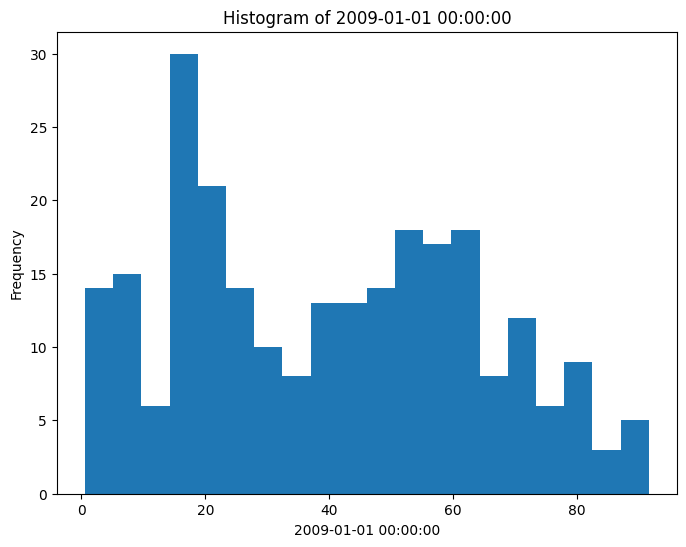

Summary statistics for column '2010-01-01 00:00:00':
count    473.000000
mean      39.521903
std       24.472878
min        0.380000
25%       18.390000
50%       36.910000
75%       59.580000
max       96.330000
Name: 2010-01-01 00:00:00, dtype: float64


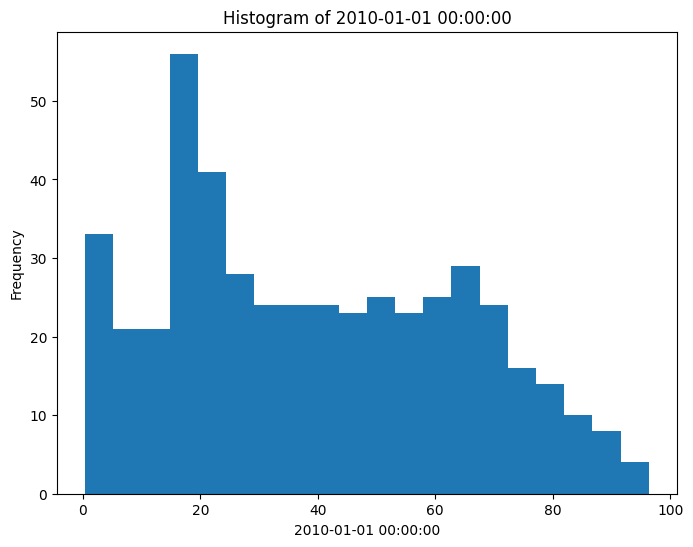

Summary statistics for column '2011-01-01 00:00:00':
count    500.000000
mean      40.252040
std       24.575746
min        0.180000
25%       19.342500
50%       38.625000
75%       61.027500
max       96.330000
Name: 2011-01-01 00:00:00, dtype: float64


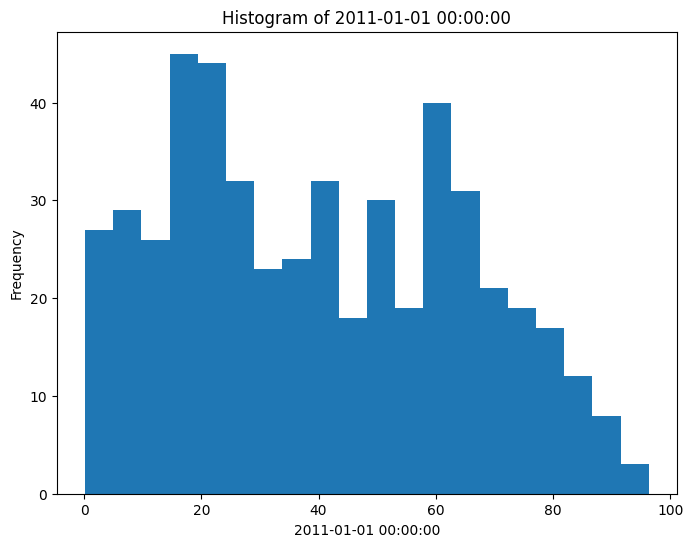

Summary statistics for column '2012-01-01 00:00:00':
count    521.000000
mean      43.642937
std       25.507767
min        0.130000
25%       20.140000
50%       44.170000
75%       65.580000
max       94.960000
Name: 2012-01-01 00:00:00, dtype: float64


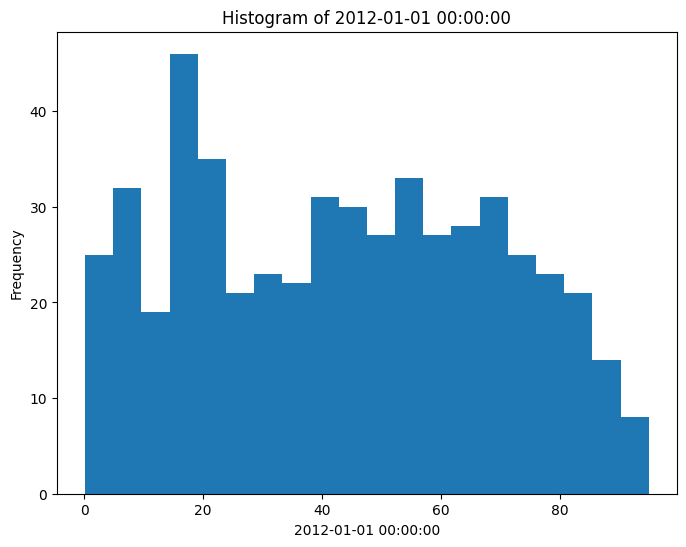

Summary statistics for column '2013-01-01 00:00:00':
count    533.000000
mean      43.919550
std       25.346947
min        0.080000
25%       21.670000
50%       43.560000
75%       64.470000
max       95.720000
Name: 2013-01-01 00:00:00, dtype: float64


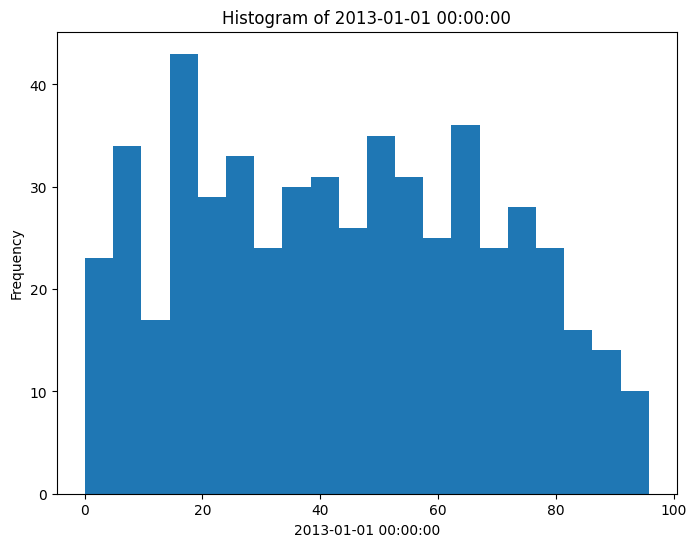

Summary statistics for column '2014-01-01 00:00:00':
count    549.000000
mean      45.456485
std       25.421063
min        0.120000
25%       23.280000
50%       46.940000
75%       65.410000
max       94.920000
Name: 2014-01-01 00:00:00, dtype: float64


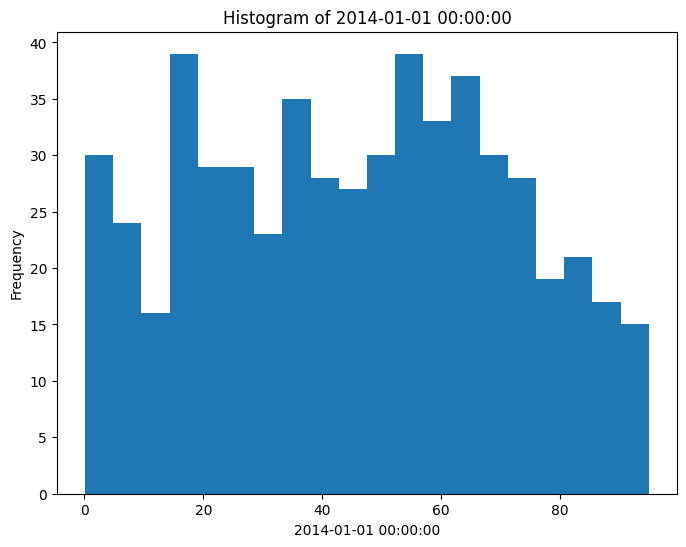

Summary statistics for column '2015-01-01 00:00:00':
count    549.000000
mean      49.477796
std       24.181819
min        0.180000
25%       30.190000
50%       52.140000
75%       69.090000
max       96.790000
Name: 2015-01-01 00:00:00, dtype: float64


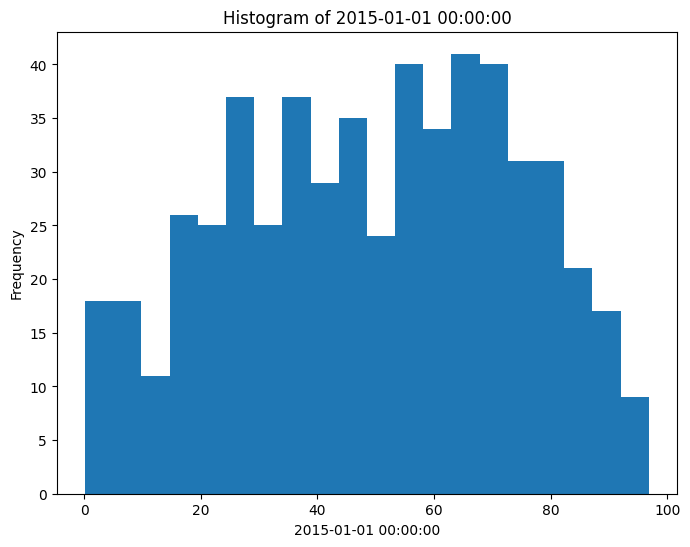

Summary statistics for column '2016-01-01 00:00:00':
count    549.000000
mean      53.295556
std       23.339855
min        0.170000
25%       36.070000
50%       55.820000
75%       71.290000
max       98.390000
Name: 2016-01-01 00:00:00, dtype: float64


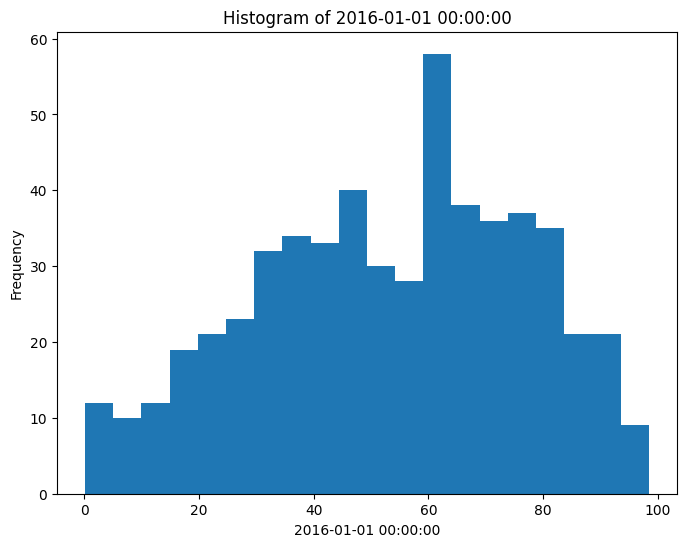

Summary statistics for column '2017-01-01 00:00:00':
count    549.000000
mean      56.699964
std       22.332445
min        0.160000
25%       40.120000
50%       60.040000
75%       74.030000
max       96.380000
Name: 2017-01-01 00:00:00, dtype: float64


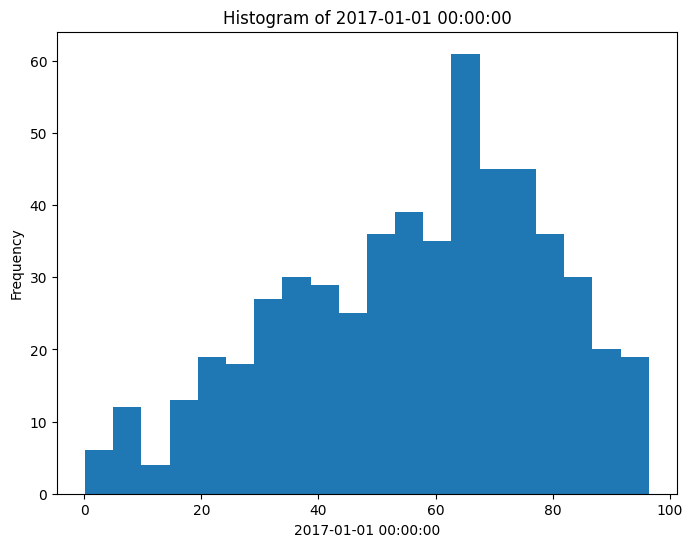

Summary statistics for column '2018-01-01 00:00:00':
count    549.000000
mean      59.088452
std       21.302523
min        0.420000
25%       43.430000
50%       61.890000
75%       75.520000
max       96.640000
Name: 2018-01-01 00:00:00, dtype: float64


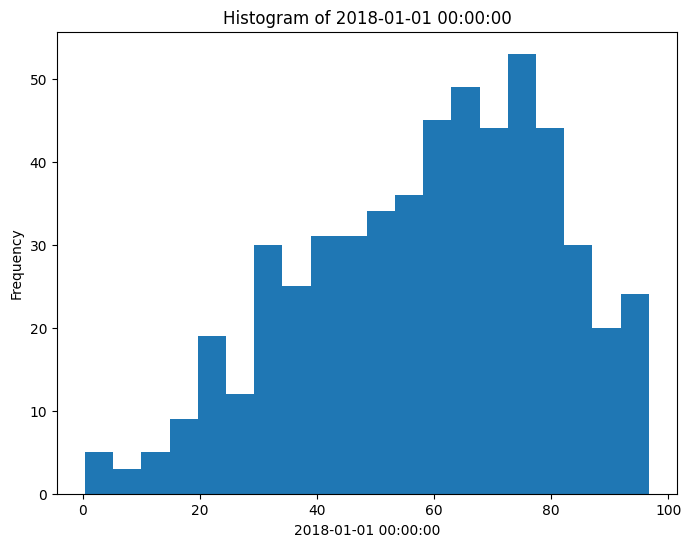

Summary statistics for column '2019-01-01 00:00:00':
count    549.000000
mean      61.760036
std       20.506534
min        1.370000
25%       48.100000
50%       64.690000
75%       77.190000
max       96.960000
Name: 2019-01-01 00:00:00, dtype: float64


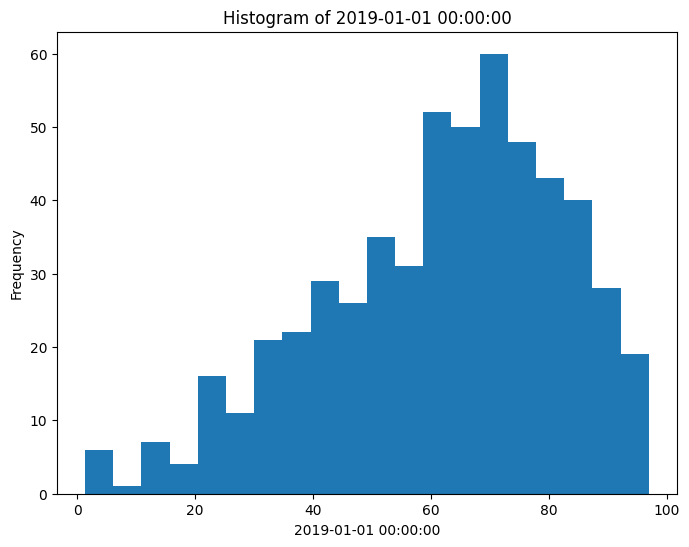

Summary statistics for column '2020-01-01 00:00:00':
count    549.000000
mean      64.071111
std       19.582507
min        1.490000
25%       51.920000
50%       67.240000
75%       78.240000
max       98.350000
Name: 2020-01-01 00:00:00, dtype: float64


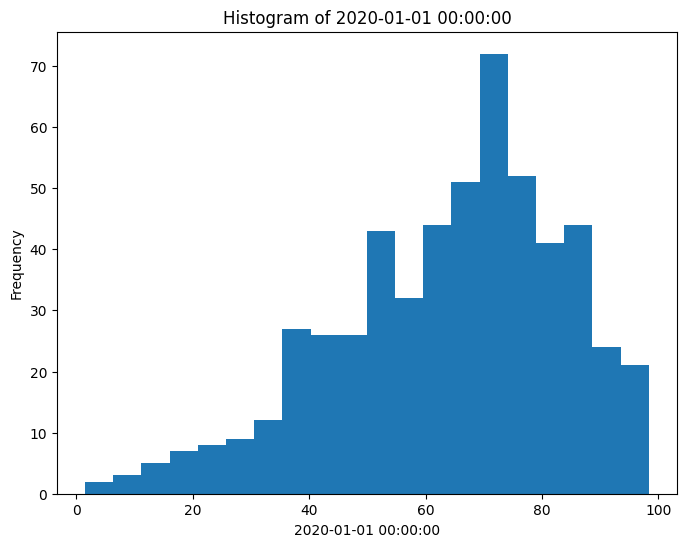

Summary statistics for column '2021-01-01 00:00:00':
count    549.000000
mean      65.856448
std       18.784408
min        4.030000
25%       54.350000
50%       68.300000
75%       80.050000
max       99.130000
Name: 2021-01-01 00:00:00, dtype: float64


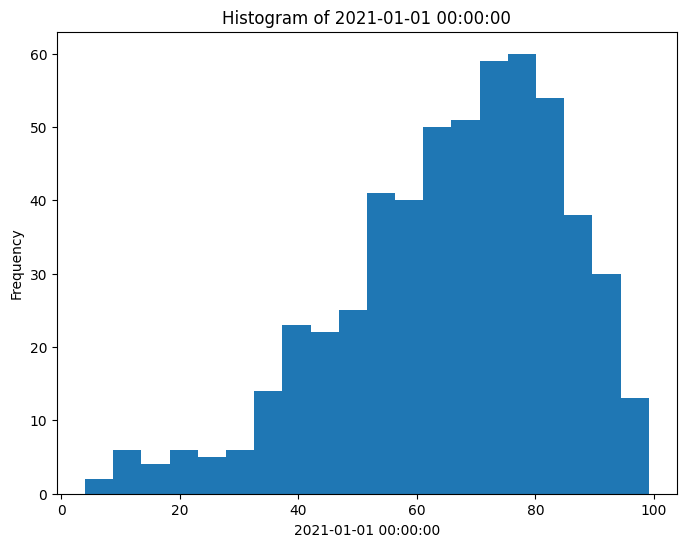

Summary statistics for column '2022-01-01 00:00:00':
count    549.000000
mean      67.687195
std       18.445124
min        5.200000
25%       57.110000
50%       70.500000
75%       81.480000
max       99.290000
Name: 2022-01-01 00:00:00, dtype: float64


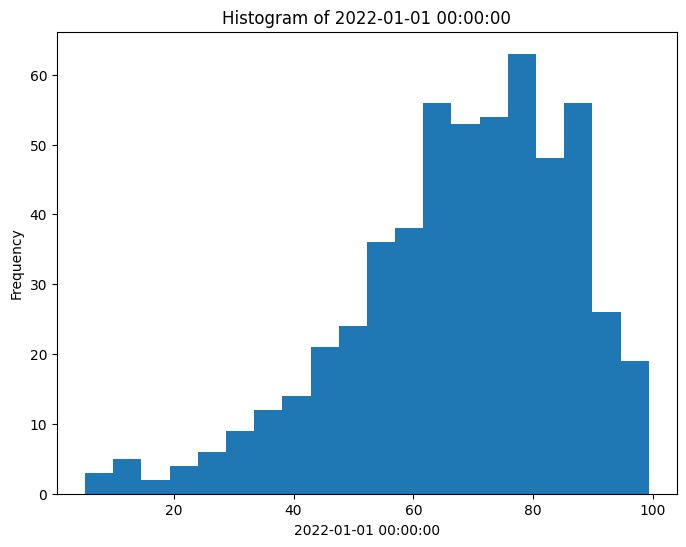

Summary statistics for column '2023-01-01 00:00:00':
count    549.000000
mean      67.930219
std       18.495435
min        5.200000
25%       57.590000
50%       70.360000
75%       82.280000
max       97.800000
Name: 2023-01-01 00:00:00, dtype: float64


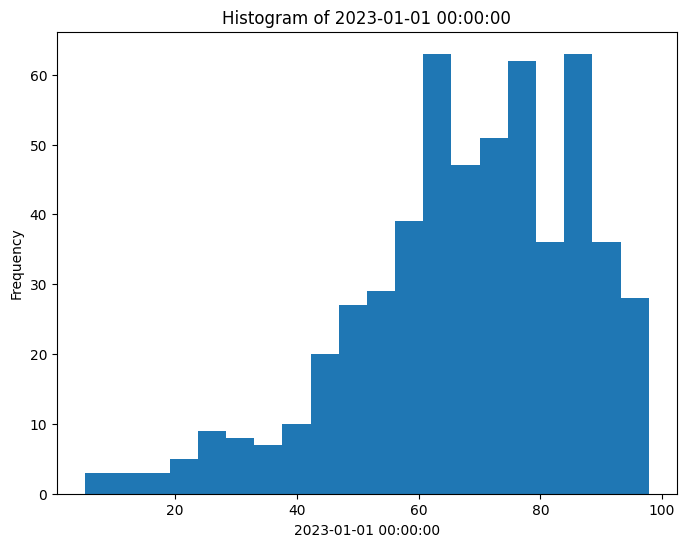

In [48]:
#Report summary statistics (mean, median, min, max, standard deviation)
for column in EM_merged_DS_EScore_Y.columns[4:]:  # Iterate through columns starting from the 5th (index 4)
    if pd.api.types.is_numeric_dtype(EM_merged_DS_EScore_Y[column]):
        # Calculate summary statistics
        print(f"Summary statistics for column '{column}':")
        print(EM_merged_DS_EScore_Y[column].describe())

        # Create a histogram
        plt.figure(figsize=(8, 6))
        plt.hist(EM_merged_DS_EScore_Y[column].dropna(), bins=20)  # Drop NaN values for histogram
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.title(f"Histogram of {column}")
        plt.show()



In [57]:
for index, row in EM_merged_DS_EScore_Y.iterrows():
  print(f"Statistics for row {index}:")
  # Extract only numerical columns for statistical calculations (exclude ISIN, Name, Country, Region)
  numerical_data = row[4:]
  print(numerical_data.describe())
  print("-" * 20)  # Separator between rows

# Create a new DataFrame to store the statistics
statistics_df = pd.DataFrame()

for column in filtered_EM_merged_DS_R_USD_M.columns[4:]:
  if pd.api.types.is_numeric_dtype(filtered_EM_merged_DS_R_USD_M[column]):
    statistics_df[column] = filtered_EM_merged_DS_R_USD_M[column].describe()

statistics_df


Statistics for row 145:
count     12.00
unique    12.00
top       57.38
freq       1.00
Name: 145, dtype: float64
--------------------
Statistics for row 146:
count     16.00
unique    16.00
top       68.98
freq       1.00
Name: 146, dtype: float64
--------------------
Statistics for row 147:
count     16.0
unique    16.0
top       78.7
freq       1.0
Name: 147, dtype: float64
--------------------
Statistics for row 148:
count     16.00
unique    16.00
top       53.61
freq       1.00
Name: 148, dtype: float64
--------------------
Statistics for row 149:
count     16.00
unique    16.00
top       58.64
freq       1.00
Name: 149, dtype: float64
--------------------
Statistics for row 150:
count     16.00
unique    16.00
top       58.82
freq       1.00
Name: 150, dtype: float64
--------------------
Statistics for row 151:
count     15.00
unique    12.00
top       53.17
freq       4.00
Name: 151, dtype: float64
--------------------
Statistics for row 152:
count     16.00
unique    15.00
top

<ipython-input-57-7b92a7592a7c>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  statistics_df[column] = filtered_EM_merged_DS_R_USD_M[column].describe()
<ipython-input-57-7b92a7592a7c>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  statistics_df[column] = filtered_EM_merged_DS_R_USD_M[column].describe()
<ipython-input-57-7b92a7592a7c>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin

,2009-01-30,2009-02-27,2009-03-31,2009-04-30,2009-05-29,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-30,...,2024-03-29,2024-04-30,2024-05-31,2024-06-28,2024-07-31,2024-08-30,2024-09-30,2024-10-31,2024-11-29,2024-12-31
count,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,...,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000
mean,-0.058987,-0.053067,0.150659,0.209021,0.192002,0.002355,0.136317,0.005110,0.083233,-0.003014,...,0.011942,0.007591,0.021509,0.017460,0.007148,0.023248,0.048096,-0.053921,-0.024033,-0.024946
std,0.128582,0.126034,0.146948,0.150230,0.191398,0.105946,0.130900,0.108288,0.091032,0.085628,...,0.109950,0.108704,0.095916,0.097947,0.089212,0.103147,0.107621,0.090930,0.082182,0.085912
min,-1.000000,-0.500000,-0.272667,-0.117062,-0.177778,-0.348558,-0.135652,-0.500000,-0.144615,-0.418919,...,-0.500000,-1.000000,-0.353538,-0.335821,-0.227298,-0.269241,-0.500000,-1.000000,-0.333333,-0.640524
25%,-0.136000,-0.125000,0.047485,0.106771,0.065698,-0.066373,0.040761,-0.062857,0.021250,-0.058824,...,-0.040411,-0.043866,-0.030735,-0.033570,-0.038530,-0.029412,-0.002849,-0.095840,-0.070783,-0.072900
50%,-0.063181,-0.046962,0.130012,0.185567,0.156849,0.000000,0.106468,0.000000,0.068643,-0.003468,...,0.000000,0.000000,0.005360,0.002983,0.000906,0.015044,0.032637,-0.056785,-0.024003,-0.020367
75%,0.011460,0.012500,0.225416,0.289609,0.273723,0.059406,0.208221,0.056326,0.135081,0.041928,...,0.048127,0.052632,0.060441,0.058884,0.054222,0.075668,0.082571,-0.006349,0.011513,0.017504
max,0.378049,0.468069,1.000000,1.000000,1.088328,0.671449,1.000000,0.478109,0.393753,0.500000,...,0.761547,0.758621,0.580053,0.833333,0.407678,1.000000,0.751979,0.433297,0.456879,0.284767


In [49]:
#Analysis 1: mean, median, min, max, std
# Calculate mean, median, min, max, and std for EM_merged_DS_EScore_Y
escore_stats = EM_merged_DS_EScore_Y.iloc[:, 4:].agg(['mean', 'median', 'min', 'max', 'std'])

# Print the statistics
escore_stats

,2009-01-01 00:00:00,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00,2013-01-01 00:00:00,2014-01-01 00:00:00,2015-01-01 00:00:00,2016-01-01 00:00:00,2017-01-01 00:00:00,2018-01-01 00:00:00,2019-01-01 00:00:00,2020-01-01 00:00:00,2021-01-01 00:00:00,2022-01-01 00:00:00,2023-01-01 00:00:00
mean,39.994803,39.521903,40.252040,43.642937,43.919550,45.456485,49.477796,53.295556,56.699964,59.088452,61.760036,64.071111,65.856448,67.687195,67.930219
median,40.455000,36.910000,38.625000,44.170000,43.560000,46.940000,52.140000,55.820000,60.040000,61.890000,64.690000,67.240000,68.300000,70.500000,70.360000
min,0.580000,0.380000,0.180000,0.130000,0.080000,0.120000,0.180000,0.170000,0.160000,0.420000,1.370000,1.490000,4.030000,5.200000,5.200000
max,91.650000,96.330000,96.330000,94.960000,95.720000,94.920000,96.790000,98.390000,96.380000,96.640000,96.960000,98.350000,99.130000,99.290000,97.800000
std,23.909240,24.472878,24.575746,25.507767,25.346947,25.421063,24.181819,23.339855,22.332445,21.302523,20.506534,19.582507,18.784408,18.445124,18.495435


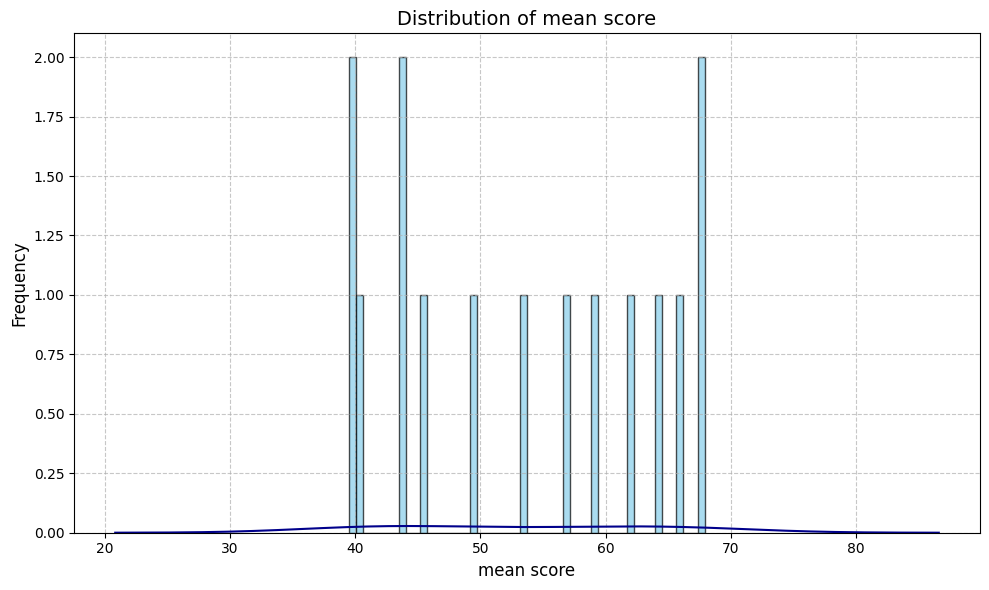

In [58]:
#Analysis 2: histogram of cross-sectional distribtuion of the score + add mean/median/min/max/std.

plt.figure(figsize=(10, 6))
plt.hist(escore_stats.iloc[0], bins=50,
         color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('mean score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of mean score', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Add KDE
sns.kdeplot( escore_stats.iloc[0], color='darkblue')

plt.show()